In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import sys

import math
from datetime import datetime
from glob import glob
from datetime import timedelta
plt.style.use('ggplot')
from mpl_toolkits.basemap import Basemap
from igrf12py.igrf12fun import runigrf12, plotigrf 
%matplotlib inline


In [2]:
#Convert julian day described in the data to datetime format
def convert_julian_frac(julian_frac, year):
    """
    julian_frac is string in the form of a float
    """
    frac, julian_day = math.modf(float(julian_frac)+1)
    #The drifters reported both 0 and 356 for julian days in the calendar year
    #When I get access to source code, I will try to determine which is correct
    if int(julian_day) > 365:
        julian_day = julian_day-365
        year = int(year) + 1
    mins, hrs = math.modf(frac*24.)
    secs, mins = math.modf(mins*60)
    usecs, secs = math.modf(secs*60)
    dval= '%s %s %s %s %s' %(year, int(julian_day), int(hrs), int(mins), int(secs))
    dtval = datetime.strptime(dval, '%Y %j %H %M %S')
    return dtval

In [3]:
def plot_drifter(lats, lons):
    #plot the tracks of the drifters
    #first we need to determine the extents of the lat/lon
    minlon = np.min(lons)
    maxlon = np.max(lons)
    minlat = np.min(lats)
    maxlat = np.max(lats)
       
    print("Extents:", minlat, maxlat, minlon, maxlon)
    #build a map
    m = Basemap(projection='merc', ellps='WGS84',
               llcrnrlat=minlat,
               urcrnrlat=maxlat,
               llcrnrlon=minlon,
               urcrnrlon=maxlon,
               resolution='h')
    
    #plot map
    plt.figure()
    for nn, drifter in enumerate(drifter_dict.keys()):
        x, y = m(np.array(lons), np.array(lats))
        m.scatter(x, y, c='r', edgecolor="None", s=3)
    m.drawcoastlines()
    plt.legend()

In [84]:
def get_model(dt, lats, lons):
    alt = 0
    # set isv to 0 (main field) because that is what it is in example ??
    isv = 0
    # set itype to 1 (geodectic)
    itype = 1
    
    simtime = dt[:10] + 'T' + dt[11:]
        
    mx,my,mz,mf,yeardec = runigrf12(simtime, isv, itype, [alt], lats, lons)
    return mx, my, mz, mf[0], yeardec

def to_total_field(x, y, z):
    """convert to total magnetic field"""
    return (x**2 + y**2 + z**2)**.5

def fix_hmr(d):
    k = np.sign(d)
    dd = abs(int(d))*10
    # convert to hex and discard last byte
    hexd = "{0:#0{1}x}".format(dd,8)[:-2]
    dd = int(hexd, 16)
    # convert to nT
    dd = (dd*6.6667)
    return dd

def get_xyz(xyz, drifter_type="APS"):
    x,y,z = [float(a) for a in xyz]
    if drifter_type == 'HMR':
        # the APS sensors were written in the wrong format, convert to correct
        x = fix_hmr(x)
        y = fix_hmr(y)
        z = fix_hmr(z)
    
    f = to_total_field(x, y, z)
    return x, y, z, f

In [172]:
def load_data(fname, drifter_type, launch_datetime='2012-06-01 00:00:00', end_datetime='2014-06-01 00:00:00'):
    """Input the name of the drifter file downloaded from the website. This function parses the two types of data,
    averaged measurements, M, and calibration measurements, C
    """
    min_bat = 11.5
    dval = open(fname, 'r')
    #initialize battery voltage
    bvalue = -1
    grf12 = -1
    cd = {"id":[], "cal_start_datetime":[], "sample_datetime":[], "num":[], 
           "x":[], "y":[], "z":[], "f":[], "temp":[], "lat":[], "lon":[], "bat":[],
          }
          
    md = {"id":[], "sample_datetime":[], "num":[], 
           "x":[], "y":[], "z":[], "f":[], "temp":[], "lat":[], "lon":[], "bat":[], 
          }
    nsams = 250
    calsx = [0]*nsams
    calsy = [0]*nsams
    calsz = [0]*nsams
    do_return = False
    cl = {"id":[],  "cal_start_datetime":[], "calsx":[], "calsy":[], "calsz":[],
          "temp":[], "lat":[], "lon":[], "bat":[]}
    
    for line in dval:
        line_vals = line.split(' ')
        
        line_vals = [x for x in line_vals if x!='']
        line_vals[-1] = line_vals[-1].strip()
      
        if line_vals[0] == 'S':
            # S: status line
            # S 000000000066760 123 270 2011.08.13 23:03:06 47.651360 -129.042221 8
            # S drifter_id rec_# day date time latitude longitude ?
            # remove the S character
            # this message is sent when the data is uploaded to the server
            #mstatus = line_vals[1:]
            d = pd.to_datetime("%s %s" %(line_vals[4], line_vals[5]))
            S_drifter_id = line_vals[1]
            S_record_num = line_vals[2]
            S_datetime = d
            S_lat = float(line_vals[6])
            S_lon = float(line_vals[7])
            
            
        if line_vals[0] == 'M':
            # M: measurement
            # M 1 -62475.9 -32540.4 -10721.9 19.39 47.9019 -128.9508 1.6 2011 224.80556 17.49
            # M meas_# xf yf zf temperature latitude longitude ? yr decimal_julian _day
            # convert julian day to something that is more easily readable
            mdt = convert_julian_frac(line_vals[10], line_vals[9])
    
            # now we have the measurement value, datetime, and battery values. This is the averaged vals
        
            # Always use the lat/lon, temp included here for the averaged data
            M_lat = float(line_vals[6])
            M_lon = float(line_vals[7])
            x, y, z, f = get_xyz(line_vals[2:5], drifter_type)

            md['lat'].append(M_lat)
            md['lon'].append(M_lon)
            md['id'].append(S_drifter_id)
            md["sample_datetime"].append(mdt)
            
            md['x'].append(z)
            md['y'].append(y)
            md['z'].append(z)
            md['f'].append(f)
            
            md['temp'].append(float(line_vals[5]))
            md['num'].append(int(line_vals[1]))
            md['bat'].append(bvalue)
            
            # set the data vals to empty so that we can append
            if do_return:
                # last few samples seem to be bad
                cl['calsx'].append(calsx)
                cl['calsy'].append(calsy)
                cl['calsz'].append(calsz)
                cl['temp'].append(ctemp)
                cl['cal_start_datetime'].append(Cdf)
                cl['bat'].append(cbvalue)
                cl['lat'].append(clat)
                cl['lon'].append(clon)
                cl['id'].append(Cid)
                calsx = [0]*nsams
                calsy = [0]*nsams
                calsz = [0]*nsams
                do_return = False
            
        if line_vals[0] == 'C':
            # The date reported here is always the start time of the sample period
            # C: Calibration header
            # C 8 2011 225.12518
            # C id yr decimal_julian_day
            jdt = convert_julian_frac(line_vals[3], line_vals[2])
            # store the calibration value
            Cid = line_vals[1]
            # store the datetime
            Cdf = jdt
            
        if line_vals[0] == 'c':
            # calibration measurement, add this to the header value for each value
            # offset the time with the measurement frequency
            # the first few and last few of this cal value seem to be bad
            C_count = int(line_vals[1])
            if C_count-1 < nsams:
                cdt = Cdf + timedelta(0, C_count)
                x, y, z, f = get_xyz(line_vals[2:5], drifter_type)
                ctemp = float(line_vals[5])
                cd["sample_datetime"].append(cdt)
                cd['x'].append(x)
                cd['y'].append(y)
                cd['z'].append(z)

                cd['temp'].append(ctemp)
                cd['num'].append(C_count)
                cd['cal_start_datetime'].append(Cdf)
                cd['bat'].append(bvalue)
                cd['lat'].append(S_lat)
                cd['lon'].append(S_lon)
                cd['id'].append(Cid)
                cd['f'].append(f)

                calsx[C_count-1] = x
                calsy[C_count-1] = y
                calsz[C_count-1] = z

                cbvalue = bvalue
                clat = S_lat
                clon = S_lon
                do_return = True

        if line_vals[0] == 'E':
            # E:
            # E 12.7 0
            # E battery_voltage ?
            bvalue = float(line_vals[1])
    
    cpd = pd.DataFrame.from_dict(cd, orient='columns')
    cpd = cpd.set_index('sample_datetime', drop=False)
    # ignore data before june 1, this will need to be tailored for each drifter
    cpd = cpd[cpd.index > pd.to_datetime(launch_datetime)]
    cpd = cpd[cpd.index < pd.to_datetime(end_datetime)]
    cpd = cpd[cpd['bat'] > min_bat]
    #remove bad latitude data
    cpd = cpd[cpd['lat'] != -90.0]
    cpd = cpd[cpd['lat'] != 0.0]

    mpd = pd.DataFrame.from_dict(md, orient='columns')
    mpd = mpd.set_index('sample_datetime', drop=False)
    # ignore data before june 1, this will need to be tailored for each drifter
    mpd = mpd[mpd.index > pd.to_datetime(launch_datetime)]
    mpd = mpd[mpd.index < pd.to_datetime(end_datetime)]
    
    # theoretically, APS should be good down to 4.95 V (+4.95V to +12V. Input current is 40mA.)
    mpd = mpd[mpd['bat'] > min_bat]
    #remove bad latitude data
    mpd = mpd[mpd['lat'] != -90.0]
    mpd = mpd[mpd['lat'] != 0.0]
    
    
    lpd = pd.DataFrame.from_dict(cl, orient='columns')
    lpd = lpd.set_index('cal_start_datetime', drop=False)
    # ignore data before june 1, this will need to be tailored for each drifter
    lpd = lpd[lpd.index > pd.to_datetime(launch_datetime)]
    lpd = lpd[lpd.index < pd.to_datetime(end_datetime)]
    
    lpd = lpd[lpd['bat'] > min_bat]
    #remove bad latitude data
    lpd = lpd[lpd['lat'] != -90.0]
    lpd = lpd[lpd['lat'] != 0.0]
    return mpd, cpd, lpd


In [175]:

#My raw files are located at data and are names as: drifter_<name>.txt
drifter_data_dir = 'data'
# I'm setting pretty conservative start/stop times based on plots of the data
drifter_dict = {
                'sneezy': {'type':'APS', 'id':66760, 'launch':'2012-08-26 00:00:00', 'end':'2012-10-12 00:00:00'}, 
                'bashful':{'type':'HMR', 'id':68740, 'launch':'2012-09-05 00:00:00', 'end':'2013-02-15 00:00:00'}, 
                'grumpy': {'type':'HMR', 'id':11070, 'launch':'2012-08-23 00:00:00', 'end':'2013-01-15 00:00:00'}, 
                'dopey':  {'type':'APS', 'id':68760, 'launch':'2012-09-15 00:00:00', 'end':'2013-01-01 00:00:00'}, 
                 # sleepy looks like the z measurement is dominating the signal 
                'sleepy': {'type':'APS', 'id':19370, 'launch':'2012-09-01 00:00:00', 'end':'2013-06-01 00:00:00'}, 
                }

for dname in drifter_dict.keys():
#for dname in ['sleepy']:
    dpath = os.path.join(drifter_data_dir, 'drifter_' + dname + '.txt')
    print("Loading %s and writing measured and calibration data files" %dname)
    drifter_type = drifter_dict[dname]['type']
    mpd, cpd, lpd = load_data(dpath, drifter_type, drifter_dict[dname]['launch'], drifter_dict[dname]['end'])
    mpd['igrfx'], mpd['igrfy'], mpd['igrfz'], mpd['igrff'], yd = get_model(drifter_dict[dname]['launch'], mpd['lat'], mpd['lon'])
    mpath = os.path.join(drifter_data_dir, 'meas_' + dname + '.txt')
    mpd.to_csv(mpath, header=True, sep=' ', index=True)
    drifter_dict[dname]['meas'] = mpd
    
    cpd['igrfx'], cpd['igrfy'], cpd['igrfz'], cpd['igrff'], yd = get_model(drifter_dict[dname]['launch'], cpd['lat'], cpd['lon'])
    cpath = os.path.join(drifter_data_dir, 'cal_' + dname + '.txt')
    cpd.to_csv(cpath, header=True, sep=' ', index=True)
    drifter_dict[dname]['cal'] = cpd

    lpd['igrfx'], lpd['igrfy'], lpd['igrfz'], lpd['igrff'], yd = get_model(drifter_dict[dname]['launch'], lpd['lat'], lpd['lon'])
    lpath = os.path.join(drifter_data_dir, 'list_' + dname + '.txt')
    lpd.to_csv(lpath, header=True, sep=' ', index=True)
    drifter_dict[dname]['list'] = lpd


Loading bashful and writing measured and calibration data files
Loading sleepy and writing measured and calibration data files
Loading sneezy and writing measured and calibration data files
Loading grumpy and writing measured and calibration data files
Loading dopey and writing measured and calibration data files


bashful


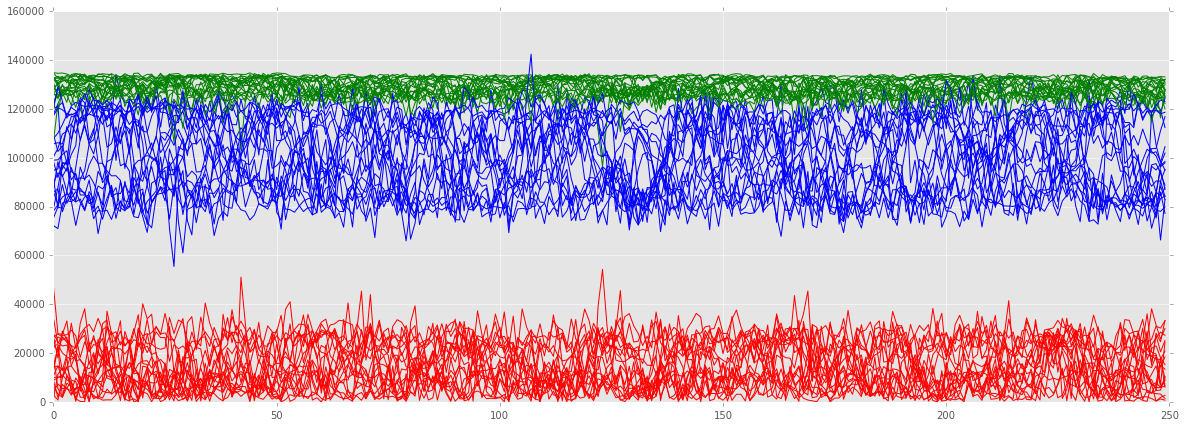

sleepy


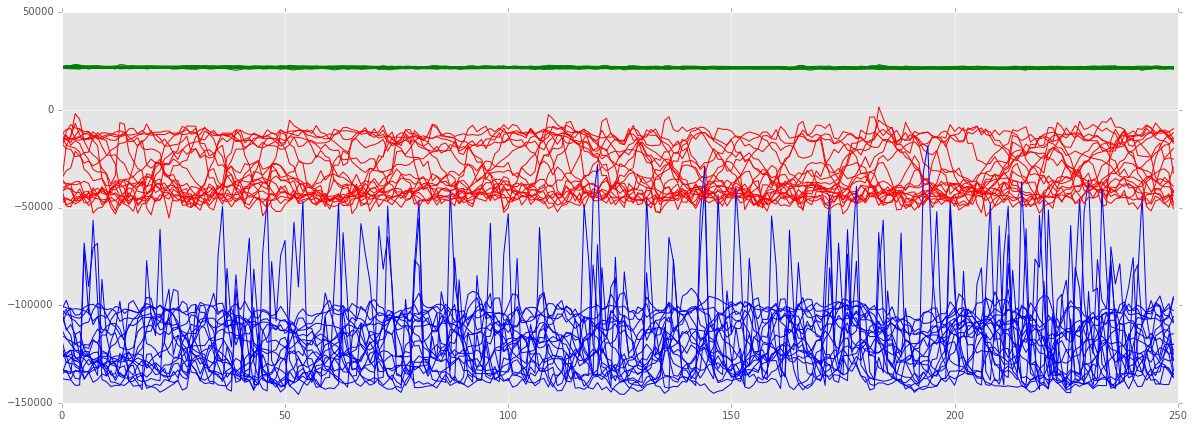

sneezy


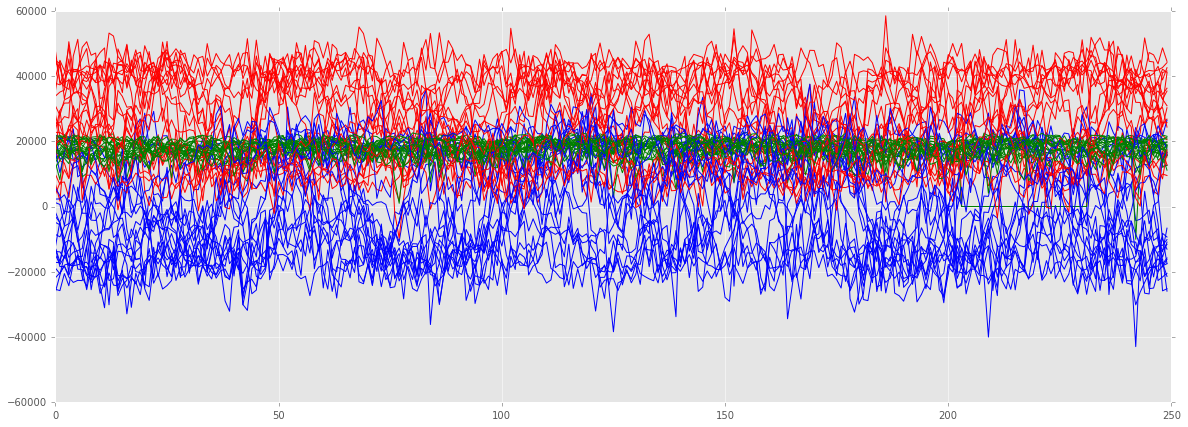

grumpy


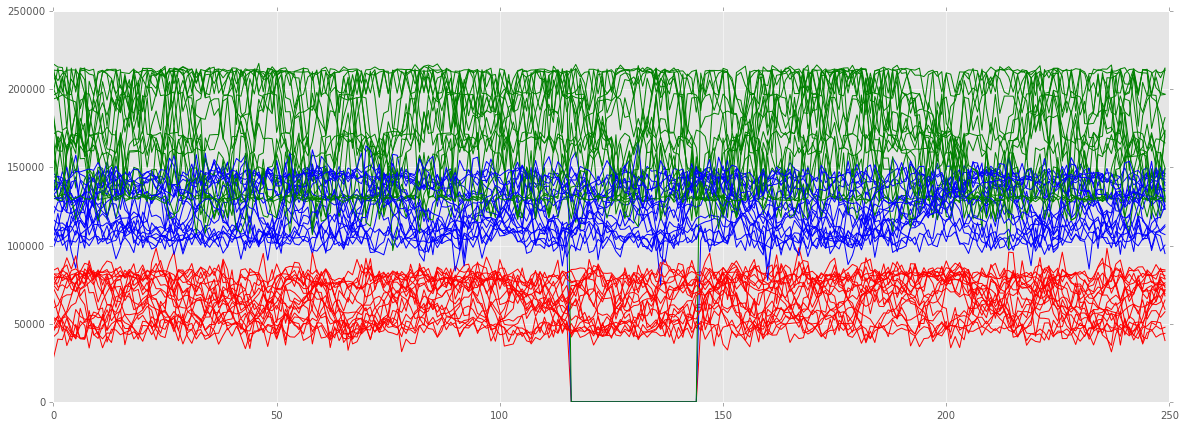

dopey


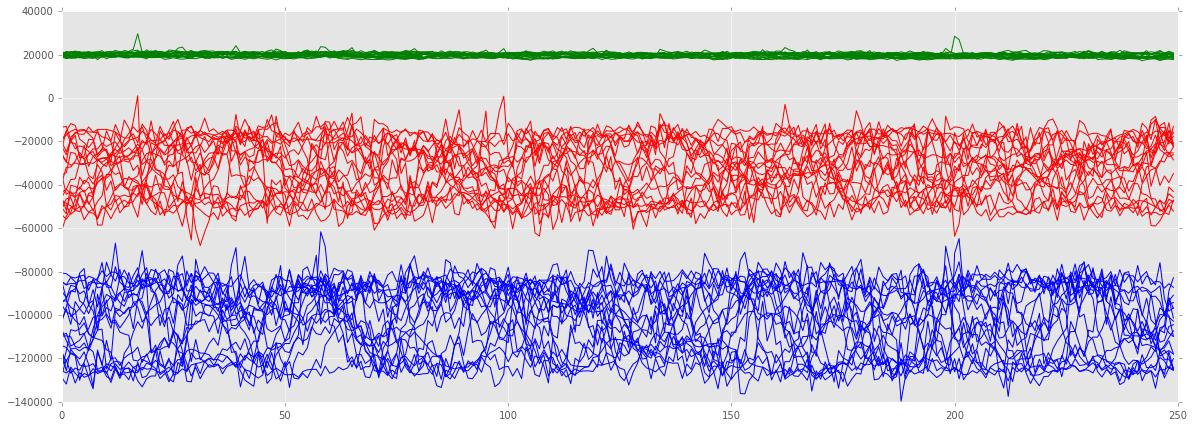

In [177]:
# look at the calibration values
for nn in drifter_dict.keys():
#for nn in ['sleepy']:
    print(nn)
    dl = drifter_dict[nn]['list']
    dl.index = range(len(dl.index))
    plt.figure(figsize=(20,7))
    for r in range(20):
        plt.plot(dl.loc[r,'calsx'], 'r')
        plt.plot(dl.loc[r,'calsy'], 'b')
        plt.plot(dl.loc[r,'calsz'], 'g')
    plt.show()

bashful


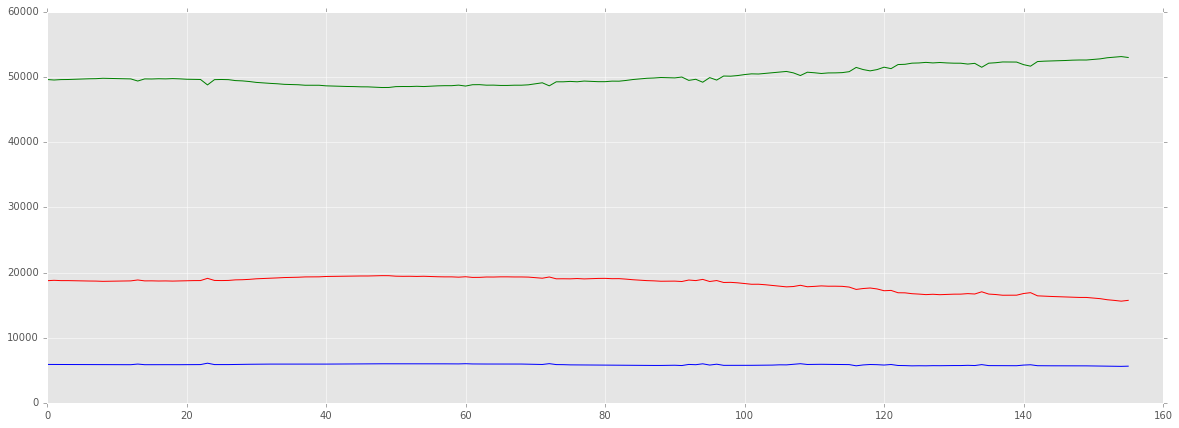

sleepy


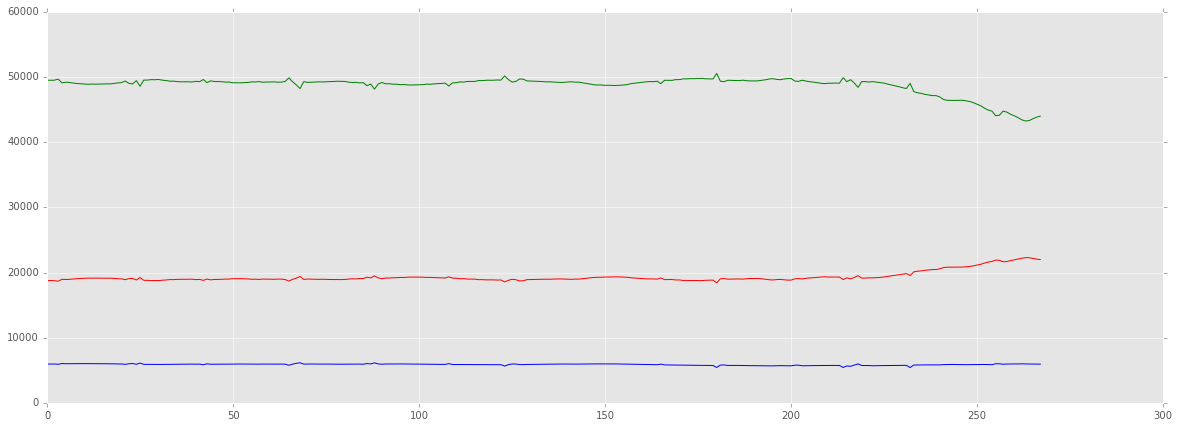

sneezy


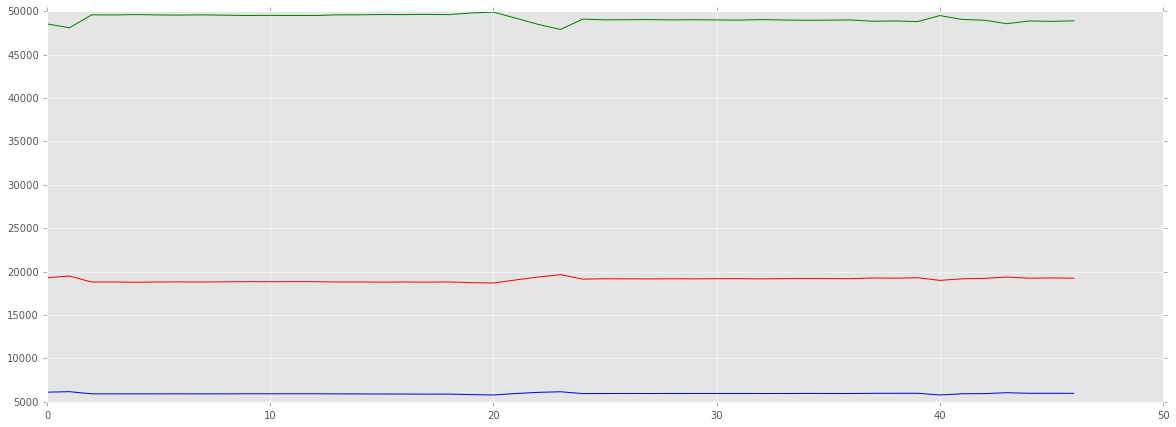

grumpy


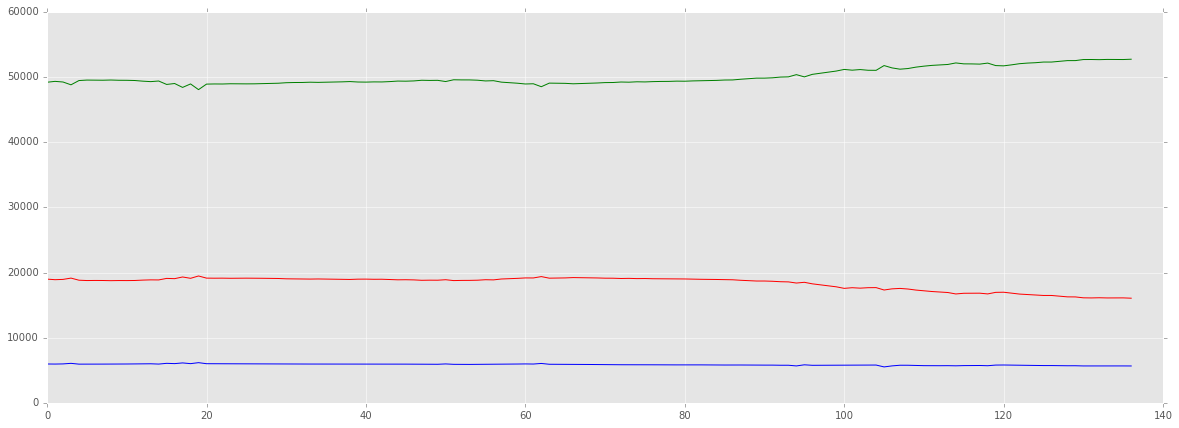

dopey


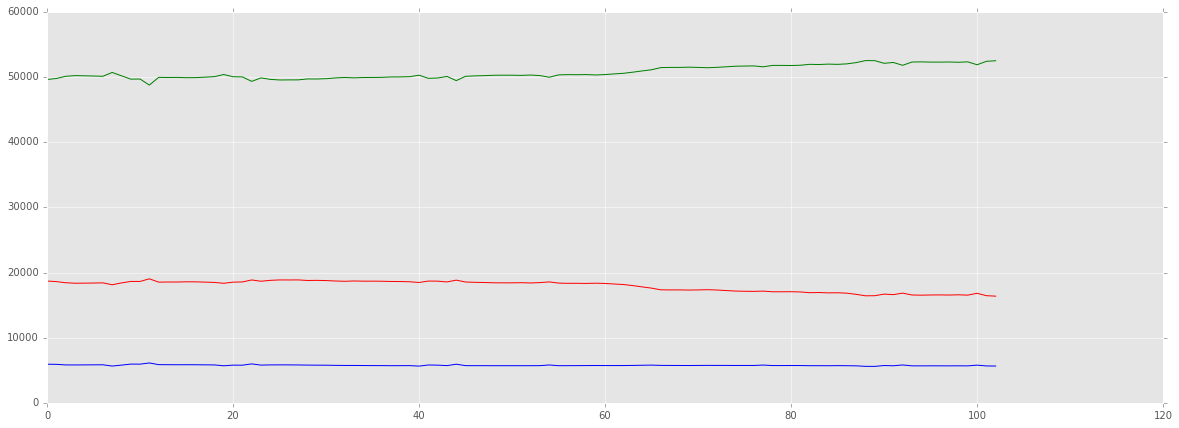

In [180]:

for nn in drifter_dict.keys():
#for nn in ['sleepy']:
    print(nn)
    dl = drifter_dict[nn]['list']
    dl.index = range(len(dl.index))
    plt.figure(figsize=(20,7))
   
    plt.plot(dl['igrfx'], 'r')
    plt.plot(dl['igrfy'], 'b')
    plt.plot(dl['igrfz'], 'g')

    plt.show()



In [ ]:
3**0